### INTRODUCTION

Our primary objective is to gain a comprehensive understanding of which patient subgroups might 
experience more favorable responses to this innovative treatment, thereby offering them the 
potential for improved outcomes. To facilitate our analysis, GSK has generously provided us with 
two datasets: clinical-study.csv and protein-levels.csv. The clinical-study.csv dataset encompasses 
detailed information on 772 patients, including essential variables such as age, weight, and, 
notably, the treatment response itself. Through careful examination, we aim to determine whether 
patients who received Miraculon-B exhibited more favorable treatment outcomes in comparison 
to those in the control group. Moreover, the protein-levels.csv dataset provides valuable insights 
into the concentration of a specific protein that could serve as a predictive biomarker for solid 
tumors. By thoroughly exploring this dataset, we hope to uncover whether factors like age, weight, 
or protein concentration can serve as indicators of a patient's likelihood to respond positively to 
Miraculon-B.

In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np  
import seaborn as sb  
import matplotlib.pyplot as plt  
from ydata_profiling import ProfileReport 

# Import modules from scikit-learn
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score 
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE

# Import LazyClassifier from lazypredict
from lazypredict.Supervised import LazyClassifier  


In [2]:
# Read data from an Excel file ('clinical-study.xlsx') and store it in the DataFrame 'df_clinical'
df_clinical=pd.read_excel('clinical-study.xlsx')

In [3]:
# Randomly selecting and displaying 5 rows from the DataFrame 'df_clinical'
df_clinical.sample(5)

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
429,SUBJ_429,50.00,Female,112.63,1.67,DRUG,N
646,SUBJ_646,77.00,Female,100.08,1.59,DRUG,N
410,SUBJ_410,66.00,Female,118.77,1.67,CONTROL,N
28,SUBJ_028,57.00,Male,64.36,1.67,CONTROL,N
70,SUBJ_070,59.00,Male,91.43,1.79,CONTROL,N


In [4]:
# Creat a copy of the DataFrame 'df_clinical' and assign it to a new DataFrame 'df'
df=df_clinical.copy()

In [5]:
# Display the first few rows of the new DataFrame 'df' to inspect its contents
df.head()

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
0,SUBJ_001,46.00,Female,84.66,1.59,DRUG,N
1,SUBJ_001,46.00,Female,84.66,1.59,DRUG,N
2,SUBJ_002,47.00,Female,71.21,1.64,DRUG,Y
3,SUBJ_003,48.00,Female,69.85,1.73,CONTROL,N
4,SUBJ_004,59.00,Female,62.94,1.50,DRUG,Y


In [6]:
# Select rows from the DataFrame 'df' that are duplicates based on all columns
df[df.duplicated()]

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
1,SUBJ_001,46.00,Female,84.66,1.59,DRUG,N


In [7]:
# Display summary information about the DataFrame 'df'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  772 non-null    object 
 1   age         772 non-null    float64
 2   sex         772 non-null    object 
 3   weight      761 non-null    float64
 4   height      772 non-null    float64
 5   trt_grp     772 non-null    object 
 6   RESPONSE    772 non-null    object 
dtypes: float64(3), object(4)
memory usage: 42.3+ KB


In [8]:
 # Remove duplicate rows from the DataFrame 'df', keep the first occurrence of each duplicate, and modify 'df' in place
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# Select and display rows from the DataFrame 'df' where the 'age' column value is less than or equal to 18
df[df.age<=18]

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
769,SUBJ_A69,7.20,Female,22.31,1.19,DRUG,N
770,SUBJ_A70,8.31,Female,24.22,1.27,CONTROL,N
771,SUBJ_A71,7.85,Male,23.18,1.26,CONTROL,N


In [10]:
# Drop rows where age is less than or equal to 18
df = df.drop(df[df['age'] <= 18].index)

In [11]:
# Remove rows from the DataFrame 'df' where the 'weight' column has missing (NaN) values, modifying 'df' in place
df.dropna(subset=['weight'], axis = 0, inplace=True)

In [12]:
# Calculate BMI using weight (kg) divided by height (m) squared
df['BMI'] = df['weight'] / (df['height'] ** 2)

In [13]:
# Display summary information about the DataFrame 'df'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 768
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  757 non-null    object 
 1   age         757 non-null    float64
 2   sex         757 non-null    object 
 3   weight      757 non-null    float64
 4   height      757 non-null    float64
 5   trt_grp     757 non-null    object 
 6   RESPONSE    757 non-null    object 
 7   BMI         757 non-null    float64
dtypes: float64(4), object(4)
memory usage: 53.2+ KB


In [14]:
# Read data from an Excel file 'protein-levels.xlsx' into DataFrame 'df2'
df2 = pd.read_excel('protein-levels.xlsx')

In [15]:
# Display the first few rows of the DataFrame 'df2'
df2.head()

,participant_id,protein_concentration
0,SUBJ_001,148.00
1,SUBJ_002,85.00
2,SUBJ_003,183.00
3,SUBJ_004,89.00
4,SUBJ_005,137.00


In [16]:
# Display summary information about the DataFrame 'df2'
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   participant_id         768 non-null    object 
 1   protein_concentration  763 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.1+ KB


In [17]:
# Rename the column 'participant_id' to 'subject_id' in DataFrame 'df2'
df2 = df2.rename(columns={'participant_id': 'subject_id'})

In [18]:
# Perform an inner join on the common column
merged_df = pd.merge(df, df2, on='subject_id')

In [19]:
# Display the first few rows of the merged DataFrame 'merged_df'
merged_df.head()

,subject_id,age,sex,weight,height,trt_grp,RESPONSE,BMI,protein_concentration
0,SUBJ_001,46.00,Female,84.66,1.59,DRUG,N,33.49,148.00
1,SUBJ_002,47.00,Female,71.21,1.64,DRUG,Y,26.48,85.00
2,SUBJ_003,48.00,Female,69.85,1.73,CONTROL,N,23.34,183.00
3,SUBJ_004,59.00,Female,62.94,1.50,DRUG,Y,27.97,89.00
4,SUBJ_005,59.00,Female,113.91,1.63,CONTROL,N,42.87,137.00


In [20]:
# Display summary information about the merged DataFrame 'merged_df'
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 756
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             757 non-null    object 
 1   age                    757 non-null    float64
 2   sex                    757 non-null    object 
 3   weight                 757 non-null    float64
 4   height                 757 non-null    float64
 5   trt_grp                757 non-null    object 
 6   RESPONSE               757 non-null    object 
 7   BMI                    757 non-null    float64
 8   protein_concentration  752 non-null    float64
dtypes: float64(5), object(4)
memory usage: 59.1+ KB


In [21]:
# Count the number of missing values in each column of the merged DataFrame 'merged_df'
merged_df.isna().sum()

subject_id               0
age                      0
sex                      0
weight                   0
height                   0
trt_grp                  0
RESPONSE                 0
BMI                      0
protein_concentration    5
dtype: int64

In [22]:
# Remove rows with missing values in the 'protein_concentration' column from the merged DataFrame 'merged_df'
merged_df.dropna(subset=['protein_concentration'], axis=0, inplace=True)

In [23]:
# Generate descriptive statistics for the numeric columns of the merged DataFrame 'merged_df' and transpose the result
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,752.00,61.74,7.09,37.00,57.00,62.00,67.00,79.00
weight,752.00,91.37,22.18,46.17,75.61,88.88,104.66,182.50
height,752.00,1.68,0.10,1.42,1.60,1.67,1.76,1.94
BMI,752.00,32.32,6.92,17.98,27.31,32.12,36.37,67.52
protein_concentration,752.00,121.94,30.60,44.00,99.75,117.00,141.00,199.00


These statistical measures provide an overview of the central tendency, variability, and distribution 
of the variables in the dataset, enabling a better understanding of their characteristics and potential 
insights for further analysis. There are 752 observations for all features after cleaning. The average 
age is 61.74. The age data has a standard deviation of 7.09, indicating a moderate amount of 
variability or spread around the mean age.The minimum and maximum age are 37 and 79 
respectively. The median age is 62. The mean and the median age are closely the same which 
means the age of the patients are almost symmetrically distributed. The average weight and height 
are 88.87kg and 1.67 meters respectively.

In [24]:
# Get the unique values in the 'trt_grp' column of the merged DataFrame 'merged_df'
merged_df.trt_grp.unique()

array(['DRUG', 'CONTROL'], dtype=object)

In [25]:
# Get the unique values in the 'RESPONSE' column of the merged DataFrame 'merged_df'
merged_df.RESPONSE.unique()

array(['N', 'Y'], dtype=object)

In [26]:
# Calculate the mean age for each treatment group
control = merged_df[merged_df['trt_grp'] == 'CONTROL']['age'].mean()
drug = merged_df[merged_df['trt_grp'] == 'DRUG']['age'].mean()

# Print the mean age for each treatment group
print(f"Mean Age - CONTROL:{control:.2f}")
print(f"Mean Age - DRUG:{drug:.2f}")

Mean Age - CONTROL:61.81
Mean Age - DRUG:61.67


In [27]:
# Calculate the mean age for each RESPONDER
age_yes = merged_df[merged_df['RESPONSE'] == 'Y']['age'].mean()
age_no = merged_df[merged_df['RESPONSE'] == 'N']['age'].mean()

# Print the mean age for each RESPONDER
print(f"Mean Age - YES: {age_yes:.2f}")
print(f"Mean Age - NO: {age_no:.2f}")

Mean Age - YES: 61.85
Mean Age - NO: 61.66


In [28]:
# Filter the DataFrame for yesand No responders in DRUG
drug_yes = merged_df[(merged_df['trt_grp'] == 'DRUG') & (merged_df['RESPONSE'] == 'Y')].shape[0]
drug_no = merged_df[(merged_df['trt_grp'] == 'DRUG') & (merged_df['RESPONSE'] == 'N')].shape[0]

# Filter the DataFrame for yes and No responders in CONTROL
control_yes = merged_df[(merged_df['trt_grp'] == 'CONTROL') & (merged_df['RESPONSE'] == 'Y')].shape[0]
control_no = merged_df[(merged_df['trt_grp'] == 'CONTROL') & (merged_df['RESPONSE'] == 'N')].shape[0]
# Print the results
print(f"DRUG_YES:{drug_yes}")
print()

print(f"DRUG_NO:{drug_no}")
print()

print(f"CONTROL_YES:{control_yes}")
print()

print(f"CONTROL_NO:{control_no}")


DRUG_YES:207

DRUG_NO:168

CONTROL_YES:123

CONTROL_NO:254


In [29]:
# Calculate the mean weight for each RESPONDER
weight_yes = merged_df[merged_df['RESPONSE'] == 'Y']['weight'].mean()
weight_no = merged_df[merged_df['RESPONSE'] == 'N']['weight'].mean()

# Print the mean weight for each RESPONDER
print(f"Mean Weight - YES: {weight_yes:.2f}")
print(f"Mean Weight - NO: {weight_no:.2f}")

Mean Weight - YES: 93.19
Mean Weight - NO: 89.94


In [30]:
# Calculate the mean weight for each RESPONDER
protein_concentration_yes = merged_df[merged_df['RESPONSE'] == 'Y']['protein_concentration'].mean()
protein_concentration_no = merged_df[merged_df['RESPONSE'] == 'N']['protein_concentration'].mean()

# Print the mean weight for each RESPONDER
print(f"Mean protein_concentration - YES:{protein_concentration_yes:.2f}")
print(f"Mean protein_concentration - NO:{protein_concentration_no:.2f}")

Mean protein_concentration - YES:104.34
Mean protein_concentration - NO:135.71


## VISUALIZATION

Text(0.5, 1.0, 'Boxplot of Age by Response (Separated by Treatment Group)')

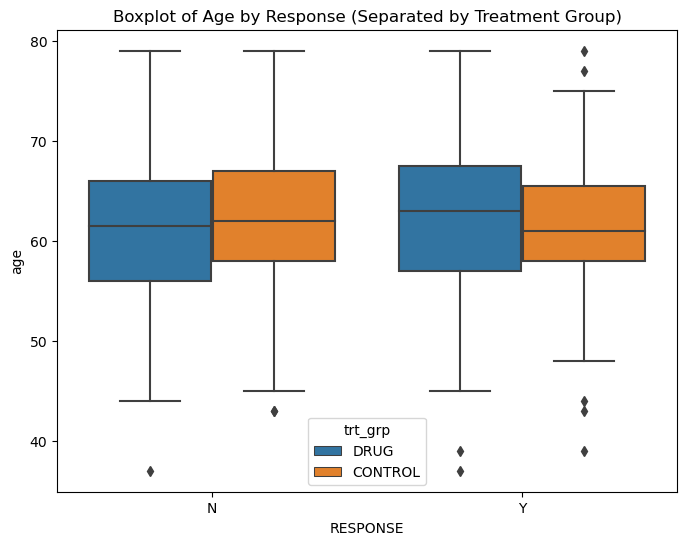

In [31]:
# Boxplot of age by response
plt.figure(figsize=(8, 6))
sb.boxplot(x=merged_df['RESPONSE'], y=merged_df['age'], hue=merged_df['trt_grp'])
plt.title('Boxplot of Age by Response (Separated by Treatment Group)')

In [32]:
# Calculate the 'weight_BMI' values by dividing 'weight' by 'BMI' for each row in the merged DataFrame
weight_BMI = merged_df['weight'] / merged_df['BMI']

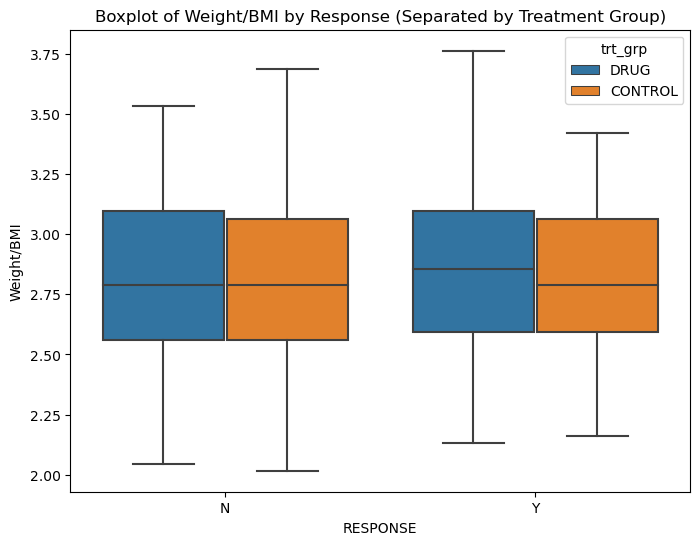

In [33]:
# Boxplot of weight/BMI by response separated by treatment group
plt.figure(figsize=(8, 6))
sb.boxplot(x=merged_df['RESPONSE'], y=weight_BMI, hue=merged_df['trt_grp']);
plt.title('Boxplot of Weight/BMI by Response (Separated by Treatment Group)');
plt.ylabel('Weight/BMI');

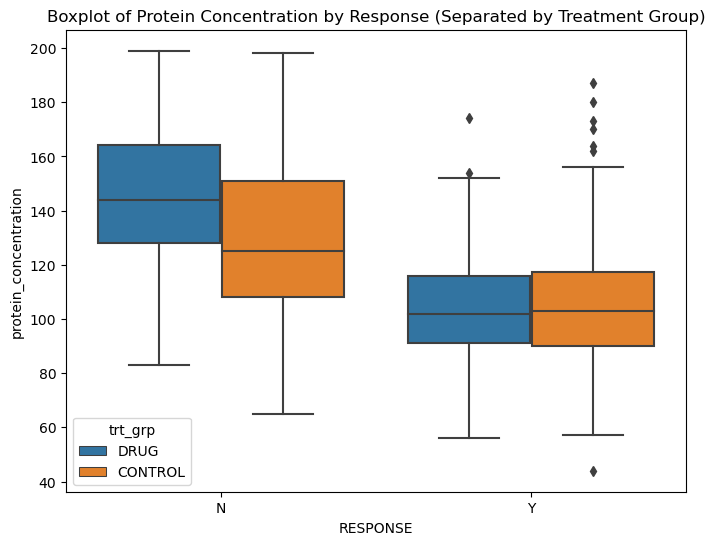

In [34]:
# Boxplot of protein_concentration by response separated by treatment group
plt.figure(figsize=(8, 6))
sb.boxplot(x=merged_df['RESPONSE'], y=merged_df['protein_concentration'], hue=merged_df['trt_grp']);
plt.title('Boxplot of Protein Concentration by Response (Separated by Treatment Group)');

The average age of individuals in the control target group is 61.81, slightly higher than the drug 
target group's average age of 61.67. This indicates a small age difference between the two groups, 
suggesting some overlap in their age distributions. Regarding responder type, the mean age of 
"Yes" responders is 61.85, slightly higher than the mean age of "No" responders at 61.66. The 
difference is again small, indicating some age distribution overlap between the two responder 
groups. Moving on to weight, "Yes" responders have a higher average weight of 93.19 compared 
to "No" responders, who have an average weight of 89.94. The difference in mean weight is 
notable, with "Yes" responders having a mean weight 3.25 units higher than "No" responders.
Lastly, in terms of protein concentration, "No" responders have a significantly higher mean protein
concentration of 135.71, compared to "Yes" responders with a mean of 104.34. This indicates a 
substantial difference of 31.37 units between the two groups' mean protein concentrations.


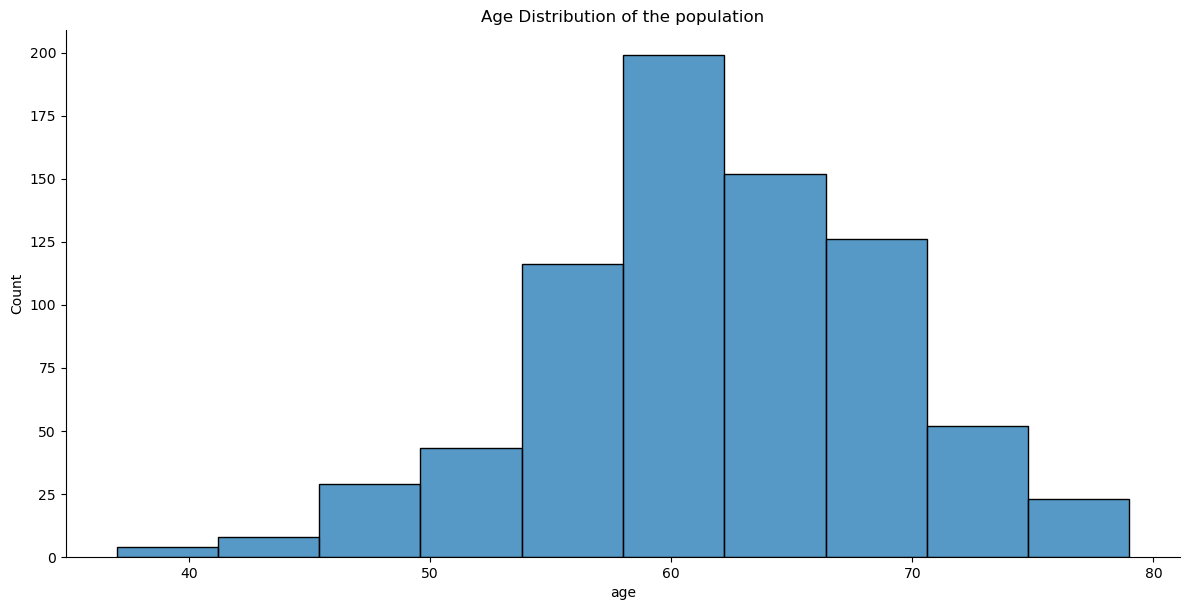

In [35]:
#Univariate plot of Age using bin_width of 5
Age_plot = sb.displot(merged_df.age, bins=10, height=6, aspect=2).set(title="Age Distribution of the population")

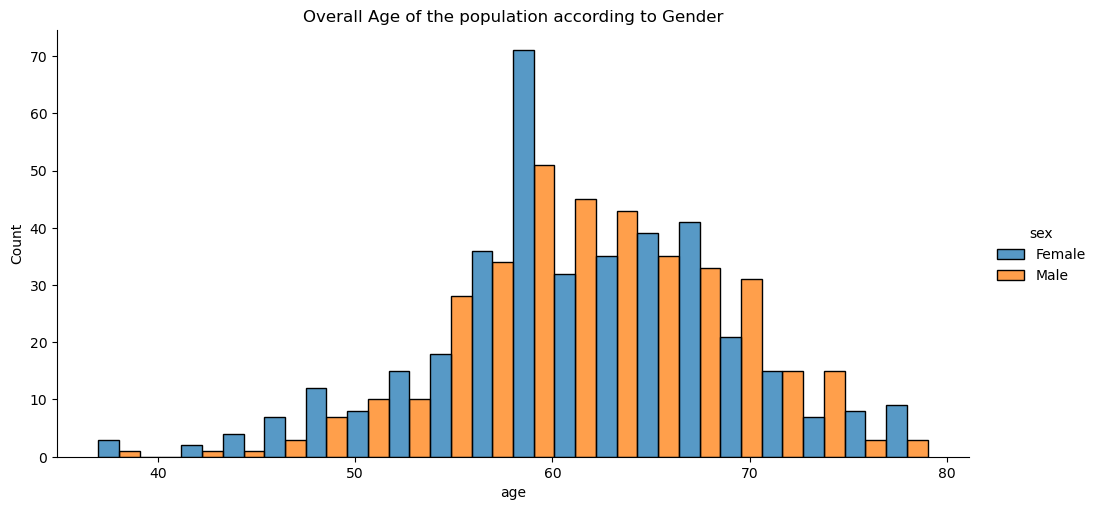

In [36]:
#Univariate plot of Age conditioned on Gender
Age_Gender_plot = sb.displot(data=merged_df, x=merged_df.age, hue='sex', kind='hist',multiple='dodge',height=5, aspect=2).set(title="Overall Age of the population according to Gender")

it is evident that a significant portion of the respondents belong to the age 
group ranging from 55 to 70 years. This age range represents the majority of the individuals who 
participated in the study or survey. Additionally, the plot indicates that there is a higher number of 
female respondents compared to male respondents. This suggests that the female population has a 
greater representation or participation in the data being analyzed

Text(0.5, 1.0, 'Response according to Gender Plot')

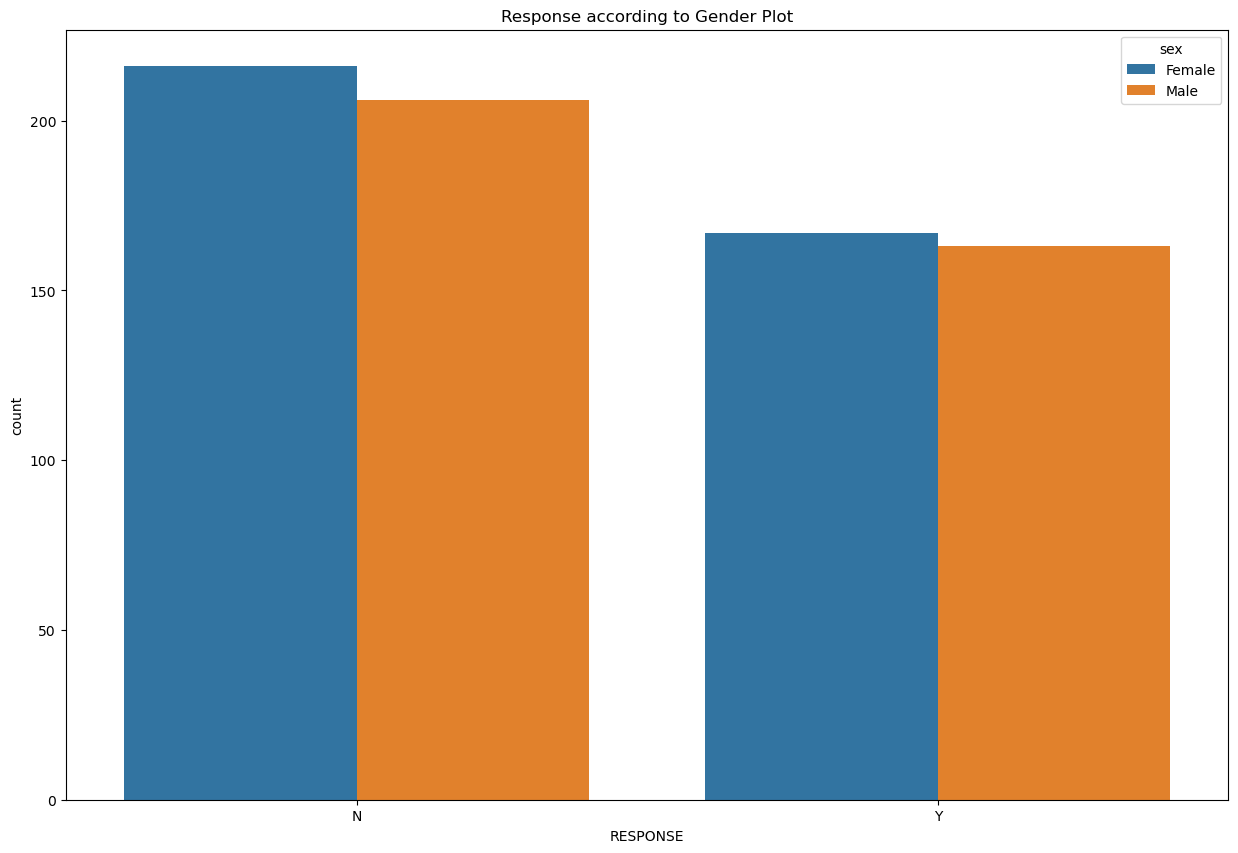

In [37]:
plt.figure(figsize=[15,10])
sb.countplot(data=merged_df, x='RESPONSE', hue='sex')
plt.title('Response according to Gender Plot')

Text(0.5, 1.0, 'Target according to Gender Plot')

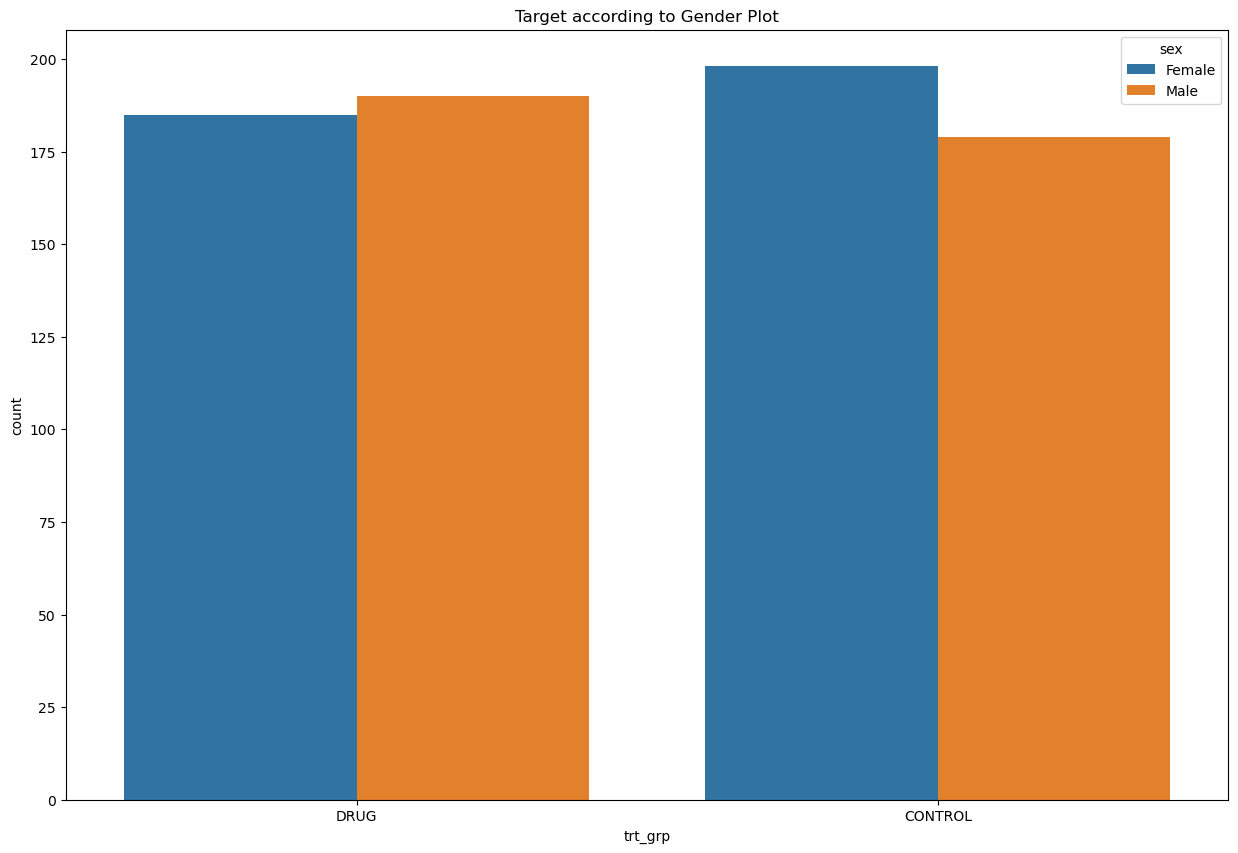

In [38]:
# Create a countplot using Seaborn
plt.figure(figsize=[15,10])
sb.countplot(data=merged_df, x='trt_grp', hue='sex')
plt.title('Target according to Gender Plot')

Text(0.5, 1.0, 'RESPONSE according to target Plot')

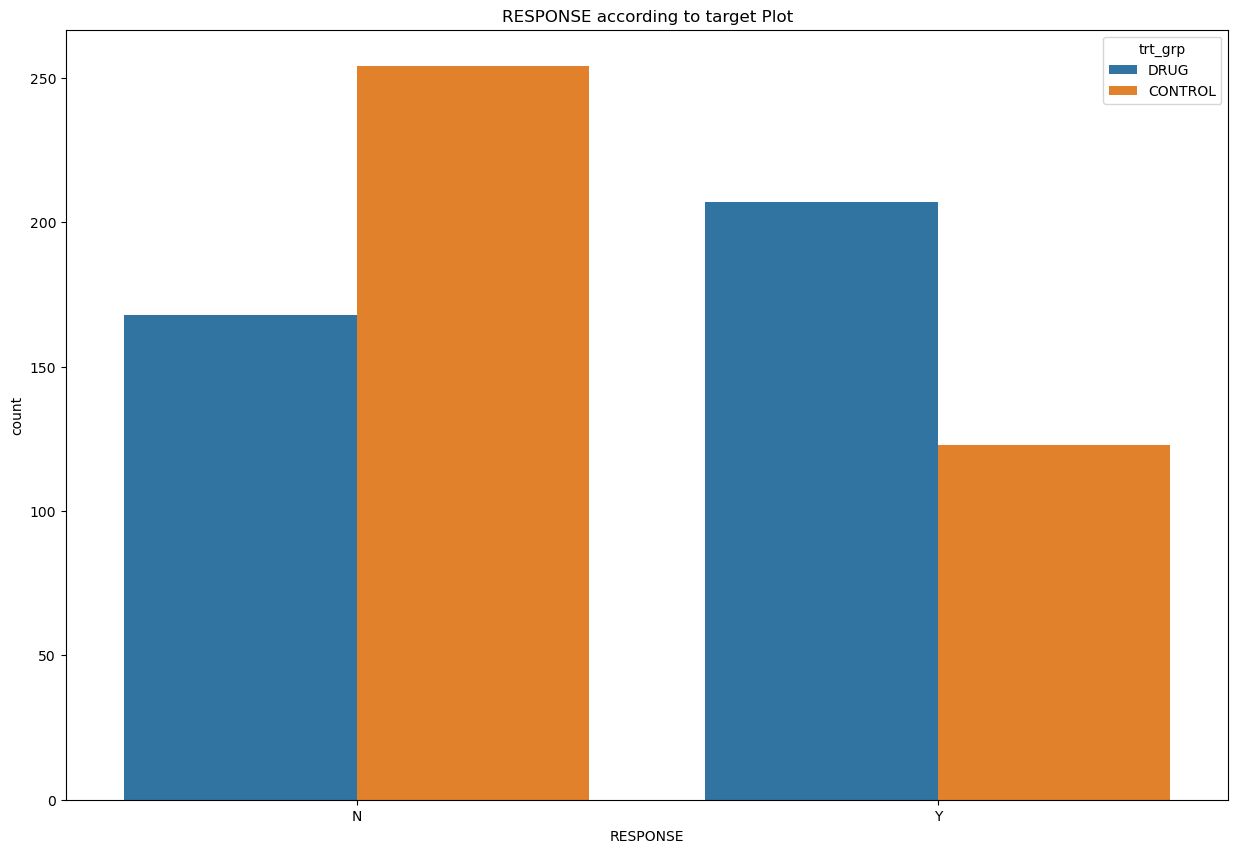

In [39]:
# Create a countplot using Seaborn
plt.figure(figsize=[15,10])
sb.countplot(data=merged_df, x='RESPONSE', hue='trt_grp')
plt.title('RESPONSE according to target Plot')

In the Drug target group, there are 207 individuals who responded with "YES," while 168 
individuals responded with "NO." On the other hand, in the Control target group, there are 123 
individuals who responded with "YES," and 254 individuals responded with "NO."
These numbers provide insights into the distribution of responses within each target group. In the 
Drug target group, a higher number of individuals responded with "YES" compared to "NO," 
indicating a greater inclination towards the positive response. Conversely, in the Control target 
group, the majority of individuals responded with "NO," outnumbering those who responded with 
"YES."


In [40]:
# Select columns with numeric data types (excluding "object" type) from the merged DataFrame
merged_numeric = merged_df.select_dtypes(exclude="object")

# Display the DataFrame containing only numeric columns
merged_numeric


,age,weight,height,BMI,protein_concentration
0,46.00,84.66,1.59,33.49,148.00
1,47.00,71.21,1.64,26.48,85.00
2,48.00,69.85,1.73,23.34,183.00
3,59.00,62.94,1.50,27.97,89.00
4,59.00,113.91,1.63,42.87,137.00
...,...,...,...,...,...
752,61.00,82.95,1.59,32.81,101.00
753,65.00,112.86,1.76,36.43,122.00
754,60.00,81.03,1.77,25.86,121.00
755,53.00,88.67,1.72,29.97,126.00


<Axes: >

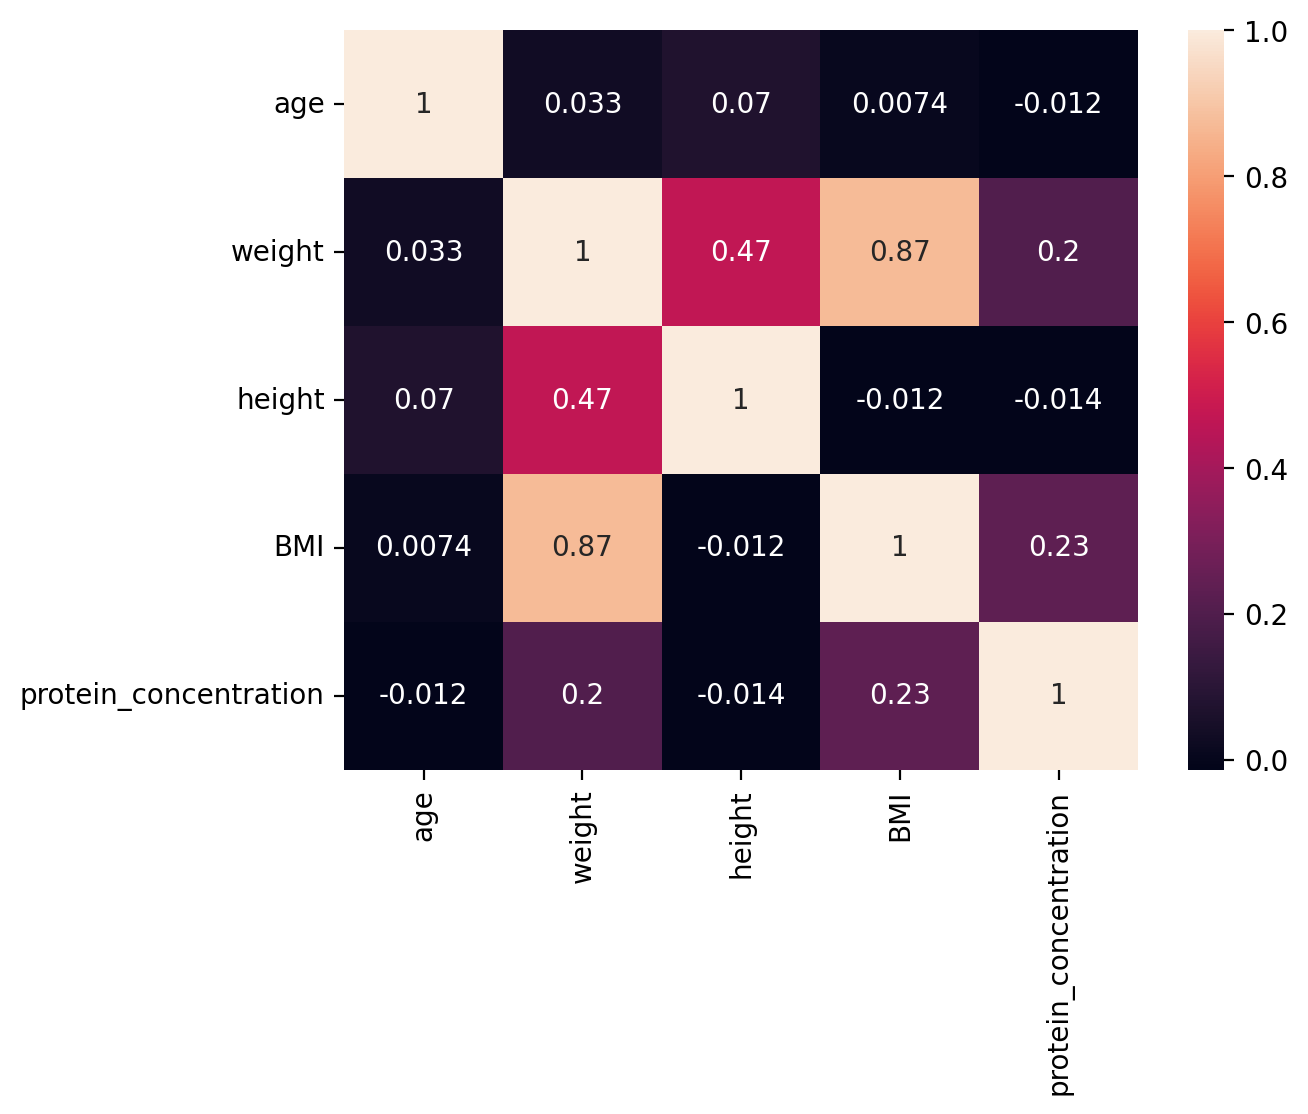

In [41]:
# Create a heatmap using Seaborn to visualize the correlation among numeric columns in 'merged_numeric'
plt.figure(dpi=200)
sb.heatmap(merged_numeric.corr(), annot = True)

The heatmap provides insights into the relationships between these features. Positive correlation 
values indicate that as one feature increases, the other feature tends to increase as well, while 
negative correlation values indicate that as one feature increases, the other feature tends to 
decrease. The strength of the correlation is determined by the magnitude of the correlation 
coefficient, with values closer to 1 indicating a stronger relationship. The heatmap displays the 
correlation between different features. The correlation coefficient between BMI and height is -
0.012, indicating a very weak negative correlation. The correlation between height and weight is 
0.47, suggesting a moderate positive correlation. BMI and weight have a correlation coefficient of 
0.87, indicating a strong positive correlation. The correlation between protein concentration and 
BMI is 0.23, representing a weak positive correlation. Height and protein concentration have a 
correlation coefficient of -0.014, indicating a very weak negative correlation. Lastly, weight and 
protein concentration have a correlation coefficient of 0.2, suggesting a weak positive correlation.

### classification

In [42]:
# Drop the column 'subject_id' from the merged DataFrame 'merged_df'
merged_df.drop(columns='subject_id', axis=1, inplace=True)

In [43]:
# Convert categorical variables into dummy variables
merged_df_new = pd.get_dummies(merged_df, drop_first=True)

In [44]:
# Get the updated list of column names in the DataFrame 'merged_df'
merged_df.columns

Index(['age', 'sex', 'weight', 'height', 'trt_grp', 'RESPONSE', 'BMI',
       'protein_concentration'],
      dtype='object')

In [45]:
# Define X and Y variables for modeling
X = merged_df_new.drop('RESPONSE_Y', axis =1)
y = merged_df_new['RESPONSE_Y']

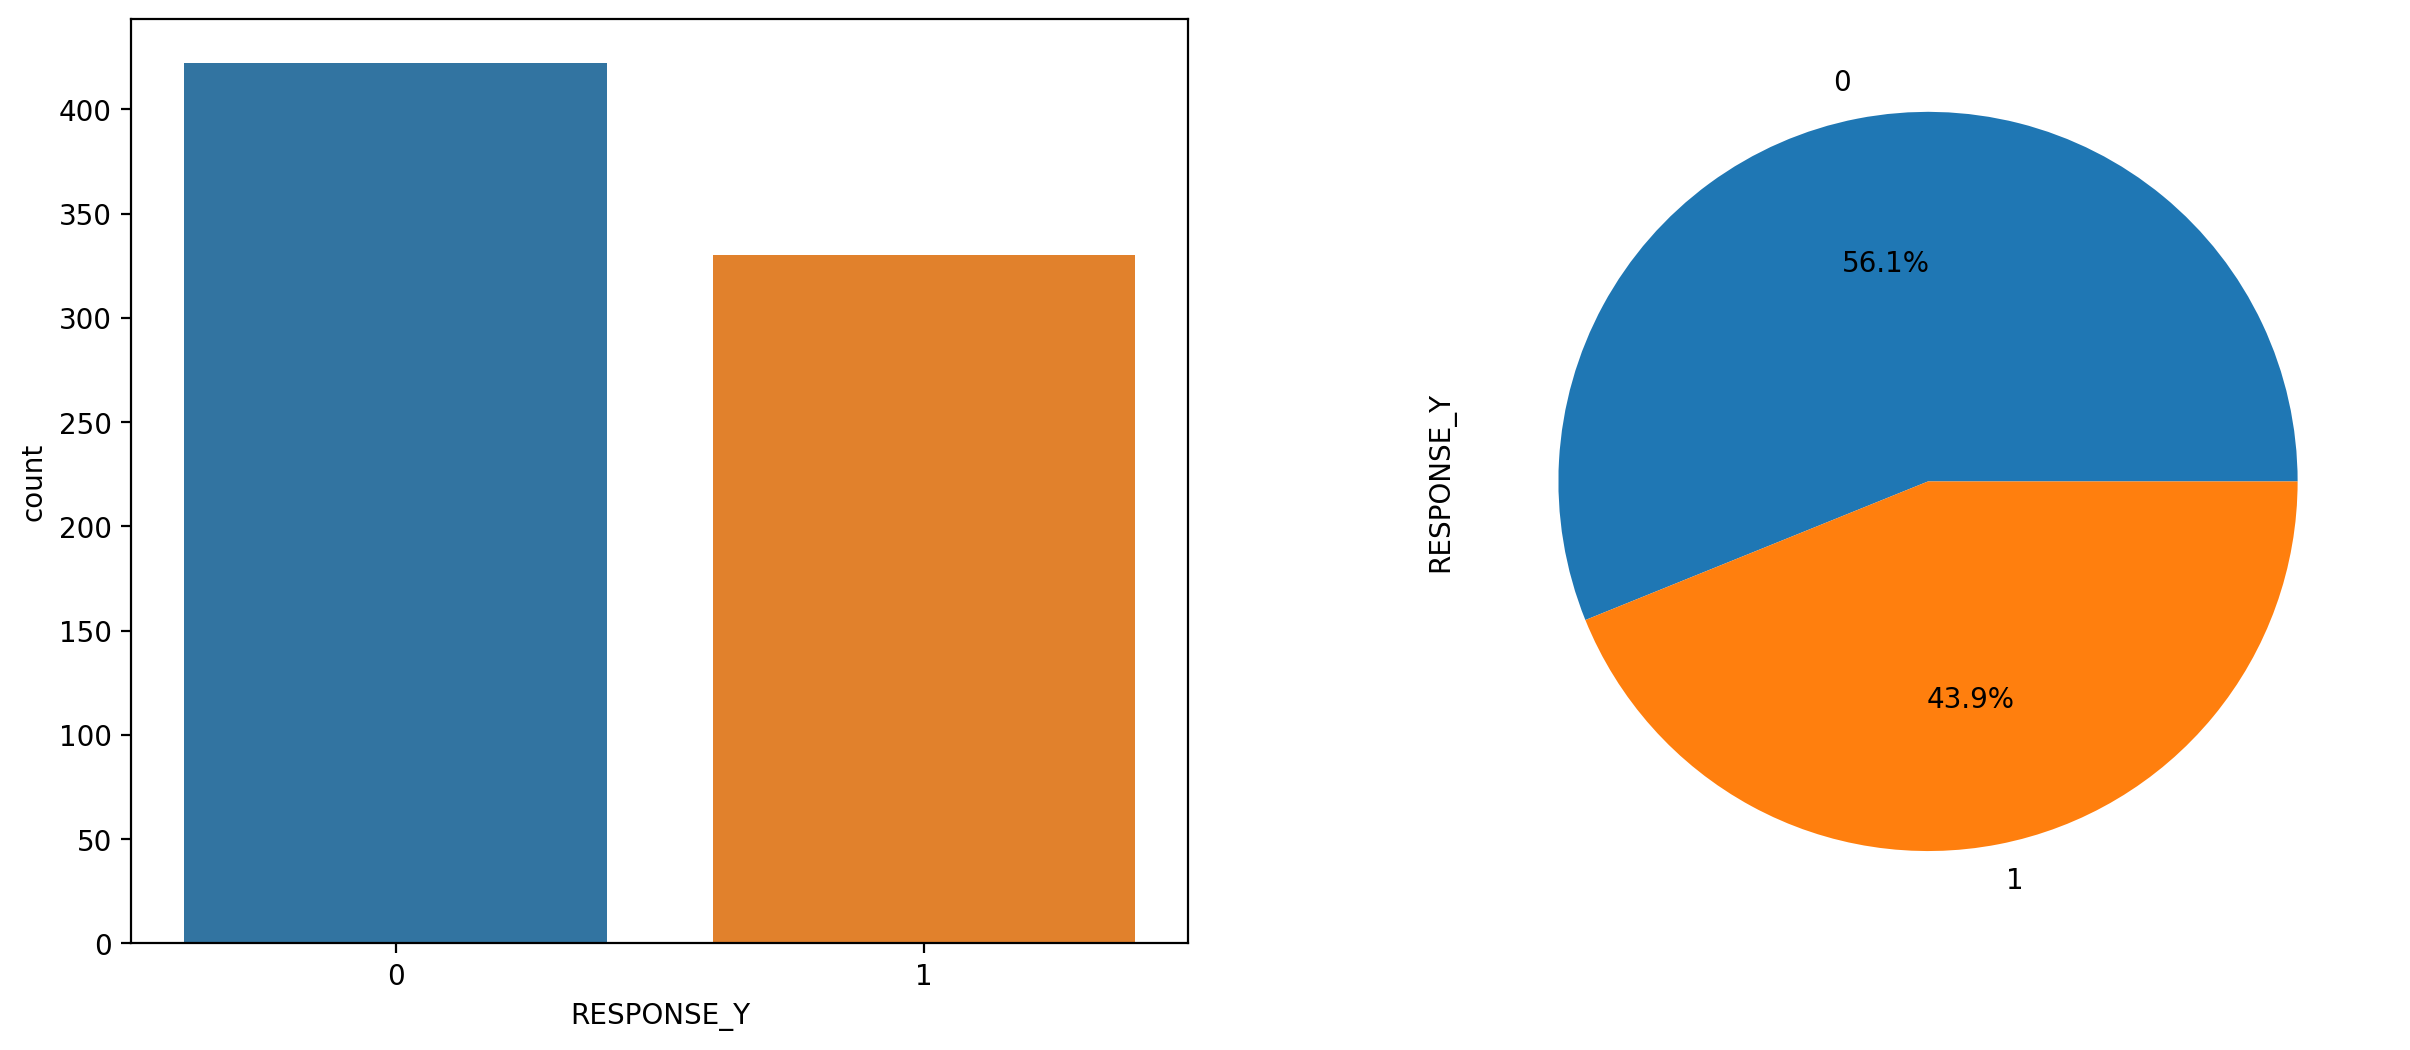

In [46]:
# Create a figure with two subplots
fig, ax_position = plt.subplots(1, 2, figsize=(15, 6), dpi=200)

# Plot a countplot for the 'Rating' column in the filtered dataset on the first subplot
a = sb.countplot(x='RESPONSE_Y', data=merged_df_new, ax=ax_position[0])

# Create a pie chart for the value counts of 'Rating' in the filtered dataset on the second subplot
a = merged_df_new['RESPONSE_Y'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax_position[1])


In [47]:
# Initialize SMOTE with specified parameters
sm = SMOTE(random_state=42, k_neighbors = 2)

In [48]:
# apply SMOTE to resample the dataset
X_res, y_res = sm.fit_resample(X, y) # The object is applied

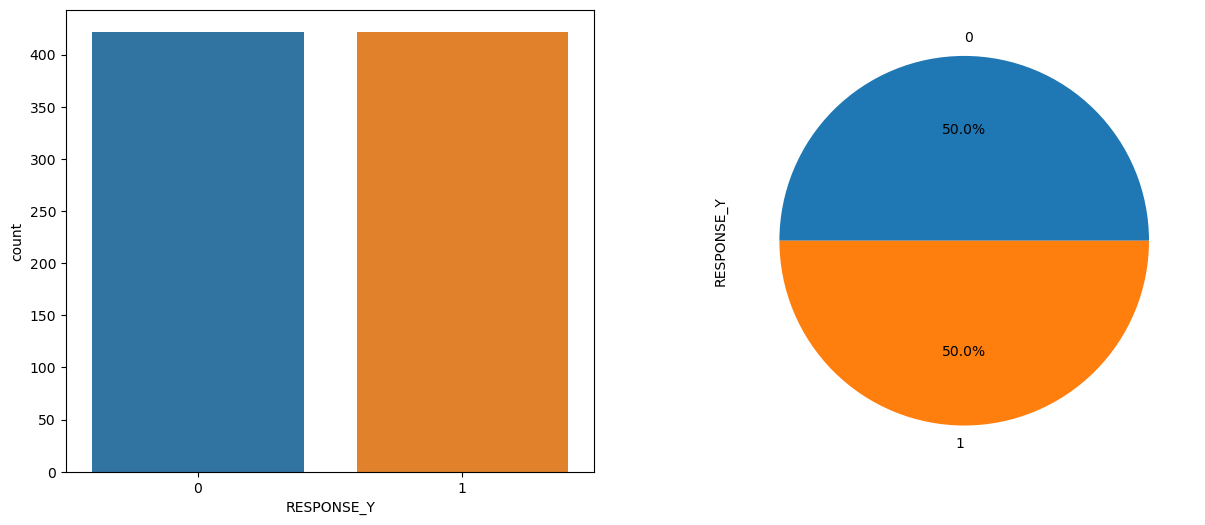

In [49]:
bal_df = pd.concat([X_res,y_res], axis = 1) # creating a dataframe for the balanced dat
fig, ax=plt.subplots(1,2,figsize=(15,6)) # creating the axis shell for subplot
a = sb.countplot(x='RESPONSE_Y',data=bal_df, ax=ax[0]) # assigning each of the plot to th
a= bal_df['RESPONSE_Y'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1]) #

In [50]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [51]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the training data and then transform it
X_train_sd = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_sd = scaler.transform(X_test)

In [52]:
# create an instance of the LazyClassifier
clf=LazyClassifier()

In [53]:
# Train the models
scores, prediction =clf.fit(X_train_sd, X_test_sd, y_train,y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.60it/s]


In [54]:
scores

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.75,0.75,0.75,0.75,0.15
NearestCentroid,0.75,0.75,0.75,0.75,0.00
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.15
LabelSpreading,0.75,0.75,0.75,0.75,0.02
LabelPropagation,0.75,0.75,0.75,0.75,0.03
LogisticRegression,0.73,0.74,0.74,0.73,0.02
LinearSVC,0.73,0.74,0.74,0.73,0.04
GaussianNB,0.73,0.73,0.73,0.73,0.01
SVC,0.73,0.73,0.73,0.73,0.03


In [60]:
# function to compute different metrics to check performance of a regression model
def model_performance_classification(model, predictors, target, threshold = 0.5):
    """
    Function to compute different metrics to check regression model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred_proba = model.predict_proba(predictors)[:, 1]
    # convert the probability to class
    pred_class = np.round(pred_proba > threshold)
    acc = accuracy_score(target, pred_class)  # to compute acuracy
    recall = recall_score(target, pred_class, average = "weighted")  # to compute recall
    precision = precision_score(target, pred_class, average="weighted")  # to compute precision
    f1 = f1_score(target, pred_class, average="weighted")  # to compute F1 score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1-score": f1
        },
        index=[0])
    conf = confusion_matrix(target, pred_class)
    plt.figure(figsize=(8, 5))
    sb.heatmap(conf, annot=True, fmt="g")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.show()
 
    return df_perf

In [61]:
# Initialize a Logistic Regression model
lr = LogisticRegression()

In [62]:
# Train the Logistic Regression model on the standardized training data
lr.fit(X_train_sd, y_train)

LogisticRegression()

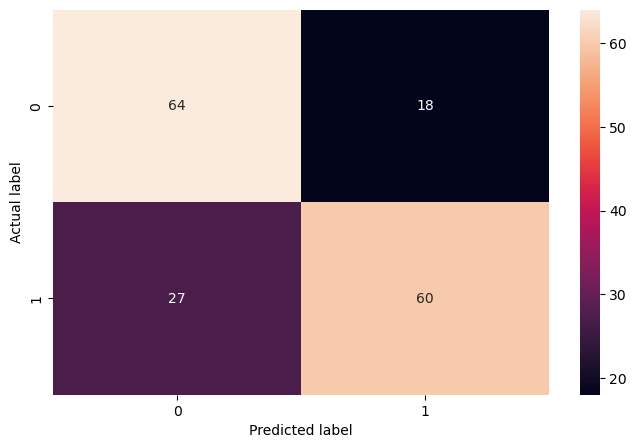

,Accuracy,Recall,Precision,F1-score
0,0.73,0.73,0.74,0.73


In [63]:
# Test the Logistic Regression model on the standardized testing data
model_performance_classification(lr, X_test_sd, y_test)

The classification report provides an assessment of the model's performance in terms of accuracy, precision, recall, and F1-score on the test set. The accuracy of the model is 0.75, meaning that it correctly classifies 75% of the instances in the dataset., a precision of 0.74, meaning that 74% of the instances predicted are correct. The recall is 0.73, indicating that the model identifies 73% of the actual instances. The F1-score for class N is 0.73, reflecting a harmonized measure of precision and recall.
The confusion matrix provides further insight into the model's predictions. It shows the counts of true negatives (correctly predicted as class N) which is 64, false positives (incorrectly predicted as class Y when they are actually class N) which is 18, false negatives (incorrectly predicted as class N when they are actually class Y) which is 27, and true positives (correctly predicted as class Y) which is 60.
